<a href="https://colab.research.google.com/github/eniofv/prev_acao_deep_learning/blob/master/Previsao_acao_LSTM_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes neurais recorrentes
Este notebook faz uma simuação de previsão de preços de ações, a partir de uma série temporal

Como pré requisito é necessario instalar a biblioteca Darts 
o comando é o:  pip install u8darts

In [1]:
pip install u8darts 


     |████████████████████████████████| 92kB 2.4MB/s 
     |████████████████████████████████| 71kB 5.0MB/s 
     |████████████████████████████████| 8.7MB 8.2MB/s 
     |████████████████████████████████| 122kB 45.1MB/s 
     |████████████████████████████████| 788kB 42.1MB/s 
     |████████████████████████████████| 1.5MB 40.4MB/s 
     |████████████████████████████████| 358kB 44.9MB/s 
     |████████████████████████████████| 2.1MB 46.8MB/s 
  Created wheel for holidays: filename=holidays-0.10.3-cp36-none-any.whl size=115855 sha256=eec3cba52409f38b6644159e63cd12d157ae4fc7e5b5cd69ffdd3ab96db5d2aa
  Stored in directory: /root/.cache/pip/wheels/d3/a6/3c/4072c36c7d443be579c0917845e1b27fc1f09d4867c41e170d
Successfully built holidays
ERROR: jupyter-console 5.2.0 has requirement prompt-toolkit<2.0.0,>=1.0.0, but you'll have prompt-toolkit 3.0.5 which is incompatible.
ERROR: google-colab 1.0.0 has requirement ipython~=5.5.0, but you'll have ipython 7.16.1 which is incompatible.
  Found existing i

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.preprocessing import ScalerWrapper
from darts.models import RNNModel
from darts.backtesting import backtest_forecasting
from darts.metrics import mape
from darts.metrics import r2_score
from darts.metrics import coefficient_of_variation
from darts.metrics import rmse
from darts.metrics import mse


import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

### Parâmetros:

In [5]:
# Número de períodos anteriores que serão considerados, 3 - meses - aprox 66 dias úteis
SEQ_LENGTH = 66
# Número de features no último estado oculto
HIDDEN_SIZE = 25
# Número de passos de saída para prever
OUTPUT_LEN = 1
# Número de camadas RNN empilhadas
NUM_LAYERS = 1
# 
BATCH_SIZE = 16
# 
EPOCAS = 400
# Modelo da rede neural - Pode se 'LSTM, 'RNN' ou 'GRU'
MODELO = 'LSTM'
# Diretório ao importar arquivos no colab o diretório default é o content
DIRETORIO = '/content/'
# Nome do arquivo de entrada
NOME_ARQUIVO = 'BBDC4_2Ano.xlsx'
#
DATA_FIM_TREINO = '20190401'
#
ACAO = 'BBDC4'

Será utilizada uma rede neural LSTM, para utlilizacão de outra rede é só substituir  ´LSTM' por 'RNN' ou ´GRU'

In [6]:
modelo_previsao_acao = RNNModel(
    model=MODELO,   # Para mudar o modelo é só substituir LSTM, RNN, ou GRU
    output_length=OUTPUT_LEN,
    hidden_size=HIDDEN_SIZE,
    n_rnn_layers=NUM_LAYERS,
    input_length=SEQ_LENGTH,
    batch_size=BATCH_SIZE,
    n_epochs=EPOCAS,
    optimizer_kwargs={'lr': 1e-3}, 
    model_name=ACAO+'_'+MODELO, log_tensorboard=True
)

Para backtest será utilizada uma rede RNN - o número de épocas é menor devido ao tempo de execução

In [7]:
modelo_previsao_acao_backtest = RNNModel(
    model='RNN',
    output_length=OUTPUT_LEN,
    hidden_size=HIDDEN_SIZE,
    n_rnn_layers=NUM_LAYERS,
    input_length=SEQ_LENGTH,
    batch_size=32,
    n_epochs=200,
    optimizer_kwargs={'lr': 1e-3},
    model_name=ACAO+'_'+MODELO+'_BACK'
)

Leitura dos dados das Ações

In [8]:
# Leitura dos dados:
Arquivo = DIRETORIO+NOME_ARQUIVO
df = pd.read_excel(Arquivo)
df.describe()



,Chave,High,Low,Open,Close,Volume,Adj Close,Adj_por_Close
count,626.000000,626.000000,626.000000,626.000000,626.000000,6.260000e+02,626.000000,626.000000
mean,312.500000,30.275756,29.426043,29.887219,29.858063,2.212256e+07,27.987240,0.938409
std,180.854914,5.721073,5.750035,5.737448,5.758516,1.339204e+07,5.425418,0.035211
min,0.000000,17.510000,16.110001,16.670000,16.950001,0.000000e+00,16.918573,0.900044
25%,156.250000,25.172950,24.333300,24.941700,24.922500,1.320510e+07,22.808707,0.909627
50%,312.500000,31.008350,30.162850,30.555300,30.659100,1.781736e+07,28.245216,0.929499
75%,468.750000,35.107500,34.307501,34.747500,34.757499,2.614284e+07,32.927048,0.963104
max,625.000000,39.939999,39.020000,39.599998,39.410000,8.078380e+07,37.261490,1.000000


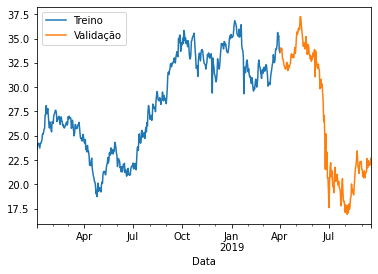

In [9]:
series = TimeSeries.from_dataframe(df, 'Data', 'Adj Close')
#
# Separa os dados de treino e validação:
treino, validacao = series.split_after(pd.Timestamp(DATA_FIM_TREINO))
treino.plot(label = 'Treino')
validacao.plot(label = 'Validação')
plt.legend()

In [10]:
series

                    0
Data                 
2018-01-02  23.592049
2018-01-03  23.699354
2018-01-04  24.088196
2018-01-05  24.224623
2018-01-06  24.217768
...               ...
2019-09-15  22.270000
2019-09-16  21.959999
2019-09-17  22.330000
2019-09-18  22.700001
2019-09-19  22.299999

[626 rows x 1 columns]
Freq: D

In [11]:
# Normaliza a série 
transforma = ScalerWrapper()
treino_transformado = transforma.fit_transform(treino)
validacao_transformado = transforma.transform(validacao)
series_transformada = transforma.transform(series)

In [12]:
treino

                    0
Data                 
2018-01-02  23.592049
2018-01-03  23.699354
2018-01-04  24.088196
2018-01-05  24.224623
2018-01-06  24.217768
...               ...
2019-03-28  35.626831
2019-03-29  35.135887
2019-03-30  35.299534
2019-03-31  33.855591
2019-04-01  33.566803

[455 rows x 1 columns]
Freq: D

In [13]:
treino_transformado

                   0
Data                
2018-01-02  0.267952
2018-01-03  0.273876
2018-01-04  0.295344
2018-01-05  0.302876
2018-01-06  0.302497
...              ...
2019-03-28  0.932375
2019-03-29  0.905271
2019-03-30  0.914305
2019-03-31  0.834587
2019-04-01  0.818644

[455 rows x 1 columns]
Freq: D

# Realiza o treino da rede neural

In [14]:
modelo_previsao_acao.fit(treino_transformado, validacao_transformado, verbose=True)  

  0%|          | 1/400 [00:00<03:17,  2.02it/s]

  3%|▎         | 11/400 [00:04<02:50,  2.29it/s]

  5%|▌         | 21/400 [00:09<02:49,  2.23it/s]

  8%|▊         | 31/400 [00:13<02:43,  2.26it/s]

 10%|█         | 41/400 [00:17<02:35,  2.31it/s]

 13%|█▎        | 51/400 [00:22<02:33,  2.28it/s]

 15%|█▌        | 61/400 [00:26<02:28,  2.28it/s]

 18%|█▊        | 71/400 [00:30<02:23,  2.29it/s]

 20%|██        | 81/400 [00:35<02:21,  2.26it/s]

 23%|██▎       | 91/400 [00:39<02:13,  2.31it/s]

 25%|██▌       | 101/400 [00:43<02:11,  2.27it/s]

 28%|██▊       | 111/400 [00:48<02:06,  2.29it/s]

 30%|███       | 121/400 [00:52<02:02,  2.27it/s]

 33%|███▎      | 131/400 [00:56<01:56,  2.30it/s]

 35%|███▌      | 141/400 [01:00<01:52,  2.30it/s]

 38%|███▊      | 151/400 [01:05<01:50,  2.26it/s]

 40%|████      | 161/400 [01:09<01:43,  2.31it/s]

 43%|████▎     | 171/400 [01:13<01:39,  2.30it/s]

 45%|████▌     | 181/400 [01:18<01:36,  2.28it/s]

 48%|████▊     | 191/400 [01:22<01:31,  2.28it/s]

 50%|█████     | 201/400 [01:26<01:26,  2.30it/s]

 53%|█████▎    | 211/400 [01:30<01:20,  2.35it/s]

 55%|█████▌    | 221/400 [01:35<01:16,  2.33it/s]

 58%|█████▊    | 231/400 [01:39<01:12,  2.33it/s]

 60%|██████    | 241/400 [01:43<01:08,  2.31it/s]

 63%|██████▎   | 251/400 [01:48<01:04,  2.30it/s]

 65%|██████▌   | 261/400 [01:52<01:00,  2.29it/s]

 68%|██████▊   | 271/400 [01:56<00:56,  2.28it/s]

 70%|███████   | 281/400 [02:00<00:51,  2.32it/s]

 73%|███████▎  | 291/400 [02:05<00:47,  2.31it/s]

 75%|███████▌  | 301/400 [02:09<00:42,  2.31it/s]

 78%|███████▊  | 311/400 [02:13<00:38,  2.32it/s]

 80%|████████  | 321/400 [02:17<00:35,  2.25it/s]

 83%|████████▎ | 331/400 [02:22<00:29,  2.31it/s]

 85%|████████▌ | 341/400 [02:26<00:25,  2.32it/s]

 88%|████████▊ | 351/400 [02:30<00:21,  2.26it/s]

 90%|█████████ | 361/400 [02:35<00:17,  2.19it/s]

 93%|█████████▎| 371/400 [02:39<00:12,  2.24it/s]

 95%|█████████▌| 381/400 [02:44<00:08,  2.18it/s]

 98%|█████████▊| 391/400 [02:48<00:04,  2.16it/s]

100%|██████████| 400/400 [02:53<00:00,  2.30it/s]


### Imprime os parâmetros utilizados no modelo


In [15]:
print(  'Parâmetros' )
print(  'Nome ' + str(modelo_previsao_acao.model_name))
print(  'Batch_size ' + str(modelo_previsao_acao.batch_size))
print(  'Optmizer ' + str(modelo_previsao_acao.optimizer))
print(  'Tamanho Entrada ' + str(modelo_previsao_acao.input_length))
#print(  'my_model.input_length ' + str(my_model.)

Parâmetros
Nome BBDC4_LSTM
Batch_size 16
Optmizer Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
Tamanho Entrada 66


# **Verifica as previsões no conjunto de validação**

In [16]:
def Avalia_modelo(modelo,dias):
    serie_previsao = modelo.predict(n=dias)
    serie_previsao_normal = transforma.inverse_transform(serie_previsao)
    plt.figure(figsize=(8,5))
    validacao.plot(label='Real')
    serie_previsao_normal.plot(label='Previsão')
    plt.title(' Modelo ' + modelo.model_name + ' MAPE: {:.2f}%'.format(mape(serie_previsao, validacao_transformado))+ '  Dias Previsão: '+str(dias))
    #print(serie_previsao)
    plt.legend();


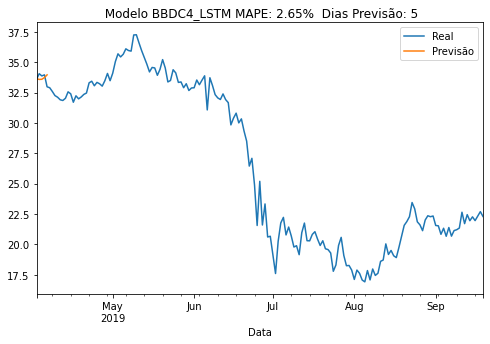

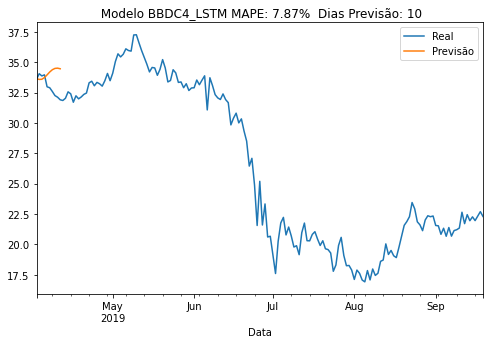

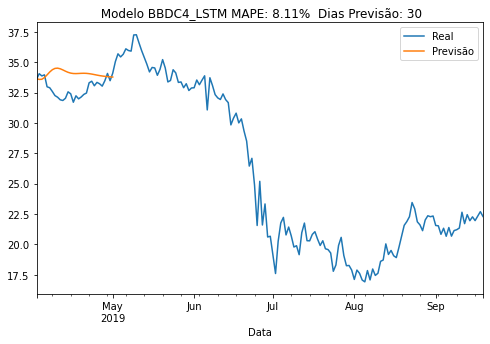

In [17]:
dias_avaliacao  = [5 , 10 , 30 ]  
for dias in dias_avaliacao:
    Avalia_modelo(modelo_previsao_acao, dias)

Utiliza o melhor modelo a partir do treino de acordo com a 'validation loss':

loading model_best_80.pth.tar


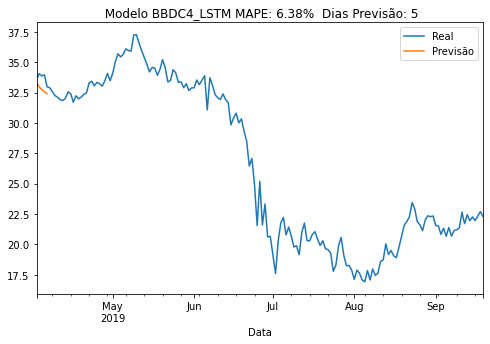

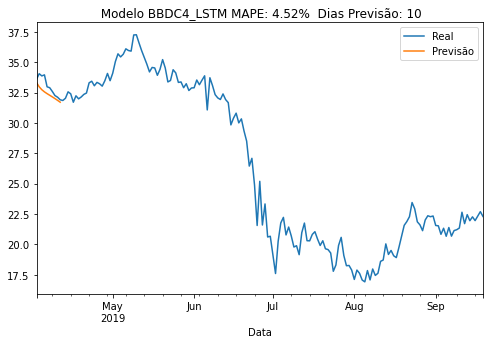

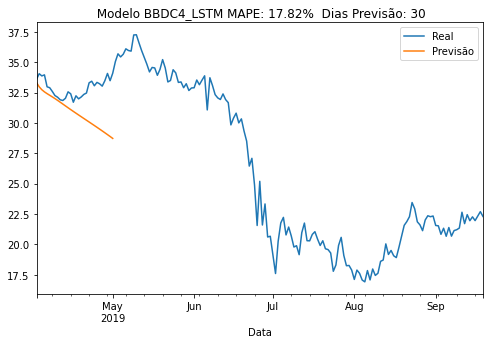

In [18]:
Melhor_modelo = RNNModel.load_from_checkpoint(model_name=ACAO+'_'+MODELO, best=True)
for dias in dias_avaliacao:
    Avalia_modelo(Melhor_modelo, dias)

### Backtesting
Realiza um backtest com um modelo  `RNN` e um horizonte de previsão de 3 meses

In [19]:
# Realiza o  backtest
backtest_series = backtest_forecasting(series_transformada, modelo_previsao_acao_backtest, pd.Timestamp('20190401'), 
                                       fcast_horizon_n=3, verbose=True)

100%|██████████| 170/170 [1:09:12<00:00, 24.43s/it]


In [20]:
backtest_series

                   0
2019-04-03  0.853465
2019-04-04  0.841796
2019-04-05  0.776437
2019-04-06  0.872504
2019-04-07  0.857255
...              ...
2019-09-15  0.197958
2019-09-16  0.187129
2019-09-17  0.200198
2019-09-18  0.265783
2019-09-19  0.133452

[170 rows x 1 columns]
Freq: D

In [21]:
series_transformada[456::]

                   0
Data                
2019-04-03  0.845615
2019-04-04  0.835512
2019-04-05  0.840298
2019-04-06  0.786063
2019-04-07  0.781809
...              ...
2019-09-15  0.194964
2019-09-16  0.177849
2019-09-17  0.198276
2019-09-18  0.218703
2019-09-19  0.196620

[170 rows x 1 columns]
Freq: D

MAPE: 6.25%


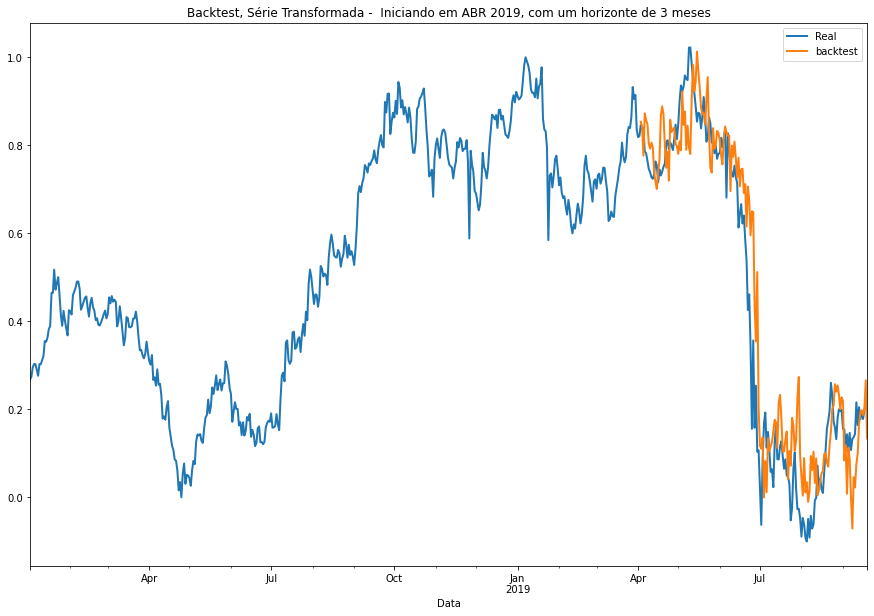

In [22]:
plt.figure(figsize=(15,10))
series_transformada.plot(label='Real', lw=2)
backtest_series.plot(label='backtest', lw=2)
plt.legend()
plt.title('Backtest, Série Transformada -  Iniciando em ABR 2019, com um horizonte de 3 meses');
print('MAPE: {:.2f}%'.format(mape(transforma.inverse_transform(series_transformada), 
                                 transforma.inverse_transform(backtest_series))))

In [23]:
serie_normal = transforma.inverse_transform(series_transformada)
serie_backtest_normal = transforma.inverse_transform(backtest_series)


MAPE: 6.25%


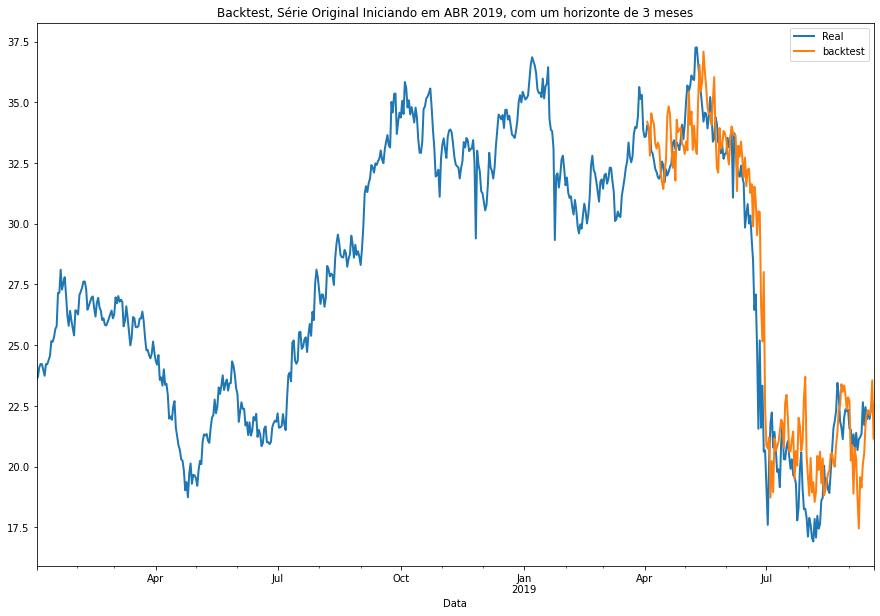

In [24]:
serie_normal
plt.figure(figsize=(15,10))
serie_normal.plot(label='Real', lw=2)
serie_backtest_normal.plot(label='backtest', lw=2)
plt.legend()
plt.title('Backtest, Série Original Iniciando em ABR 2019, com um horizonte de 3 meses');
print('MAPE: {:.2f}%'.format(mape(transforma.inverse_transform(series_transformada), 
                                 transforma.inverse_transform(backtest_series))))

# **Métricas**

In [25]:


print('***MÉTRICAS**** - Ação - ' + ACAO)
print('MAPE                    : {:.2f}%'.format(mape(serie_normal, serie_backtest_normal)))
print('Coeficiente de Variação : {:.2f}%'.format(coefficient_of_variation(serie_normal, serie_backtest_normal)))  
print('R2_score                : {:.2f}%'.format(r2_score(serie_normal, serie_backtest_normal)))                             
print('RMSE                    : {:.2f}%'.format(rmse(serie_normal, serie_backtest_normal,True)))
print('MSE                     : {:.2f}%'.format(mse(serie_normal, serie_backtest_normal,True)))

***MÉTRICAS**** - Ação - BBDC4
MAPE                    : 6.25%
Coeficiente de Variação : 7.23%
R2_score                : 0.91%
RMSE                    : 2.02%
MSE                     : 4.09%
